In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
dataset , info = tfds.load("oxford_iiit_pet:3.*.*",with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteC1SYU7/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteC1SYU7/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
def normalize(input_image,input_mask):
  input_image = tf.cast(input_image,tf.float32) /255.0
  input_mask -= 1
  return input_image,input_mask


In [ ]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

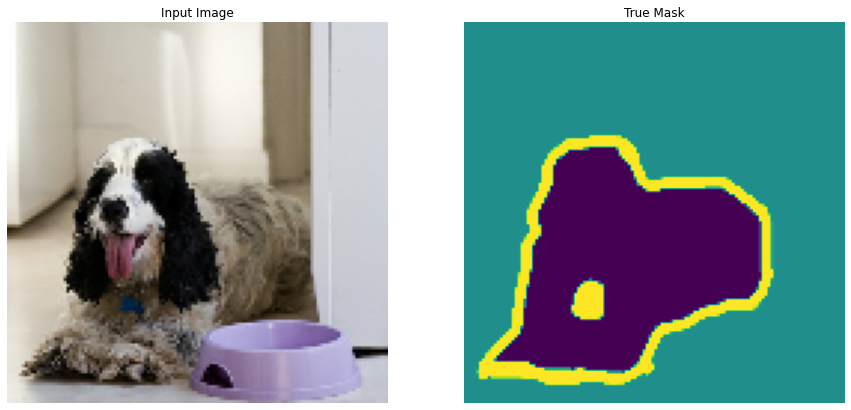

In [ ]:
for image, mask in train.take(35):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [ ]:
def down_part(input = None, n_filters = 64, dropout_prob = 0, maxpool = True):
  conv = Conv2D(n_filters,
                kernel_size = 3,
                activation = "relu",
                padding = "same",
                kernel_initializer = "he_normal")(input)
  conv = Conv2D(n_filters,
                kernel_size = 3,
                activation = "relu",
                padding = "same",
                kernel_initializer = "he_normal")(conv)
  
  if dropout_prob > 0:
    conv = Dropout(dropout_prob)(conv)

  if maxpool:
    next_layer = MaxPooling2D(pool_size =(2,2))(conv)
  else:
    next_layer = conv

  skip_connection = conv

  return next_layer,skip_connection

  
          

In [ ]:
def up_part(expand,concat,n_filters=64):
  up = Conv2DTranspose(n_filters,
                       kernel_size=(3,3),
                       strides = (2,2),
                       padding = "same")(expand)

  merge = concatenate([up,concat],axis=3)
  conv = Conv2D(n_filters,
                kernel_size=(3,3),
                activation="relu",
                padding="same",
                kernel_initializer="he_normal")(merge)
  conv = Conv2D(n_filters,
                kernel_size=(3,3),
                activation="relu",
                padding="same",
                kernel_initializer="he_normal")(conv)
  return conv

In [ ]:
def unet_model(input_size=(96, 128, 3), n_filters=64, n_classes=23):
  inputs = Input(input_size)
  
  cblock1 = down_part(inputs,n_filters)
  cblock2 = down_part(cblock1[0],n_filters*2)
  cblock3 = down_part(cblock2[0],n_filters*4)
  cblock4 = down_part(cblock3[0],n_filters*8,dropout_prob = 0.3)
  cblock5 = down_part(cblock4[0],n_filters*16,dropout_prob=0.3,maxpool=False)

  ublock1 = up_part(cblock5[0],cblock4[1],n_filters*8)
  ublock2 = up_part(ublock1,cblock3[1],n_filters*4)
  ublock3 = up_part(ublock2,cblock2[1],n_filters*2)
  ublock4 = up_part(ublock3,cblock1[1],n_filters)

  conv = Conv2D(n_filters,
                kernel_size=(3,3),
                activation="relu",
                padding="same",
                kernel_initializer="he_normal")(ublock4)
  conv = Conv2D(n_filters,
                kernel_size = (1,1),
                padding="same")(conv)


  model = tf.keras.Model(inputs=inputs,outputs = conv)

  return model



In [ ]:
unet = unet_model((128,128,3),n_classes = 3)
unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 128, 128, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_21 (Conv2D)             (None, 128, 128, 64  36928       ['conv2d_20[0][0]']              
                                )                                                           

In [ ]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = unet.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

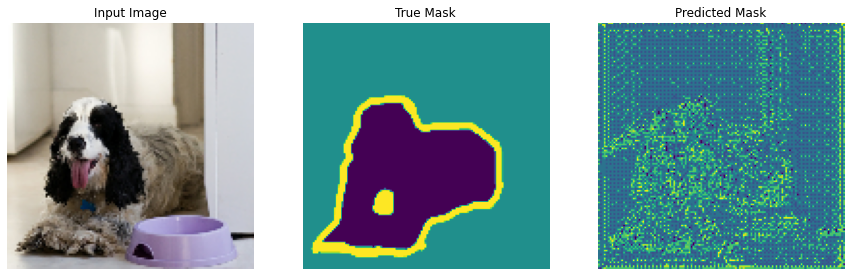

In [ ]:
show_predictions()

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

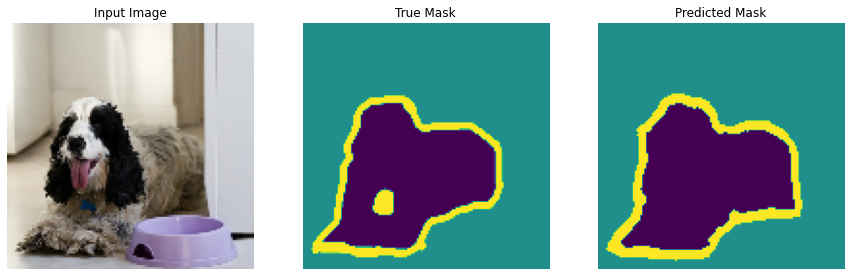


Sample Prediction after epoch 20

57/57 [==============================] - 58s 1s/step - loss: 0.2518 - accuracy: 0.8941 - val_loss: 0.3748 - val_accuracy: 0.8632


In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = unet.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

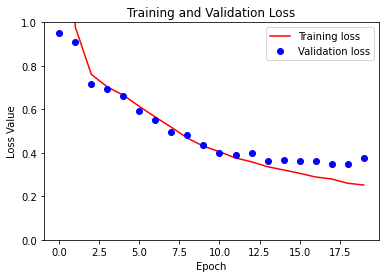

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

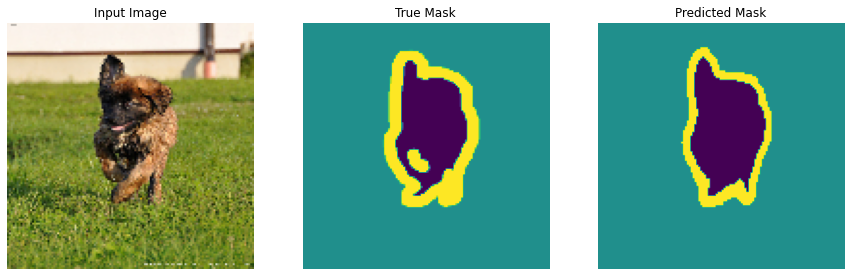

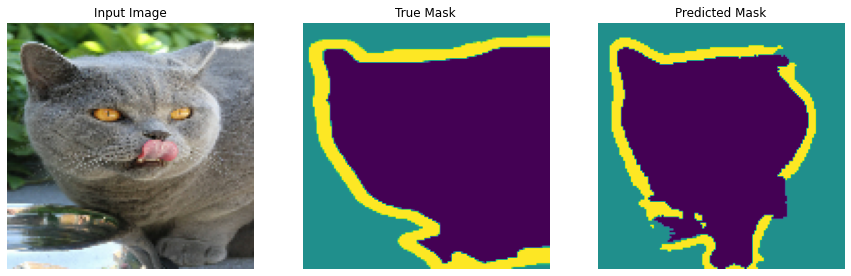

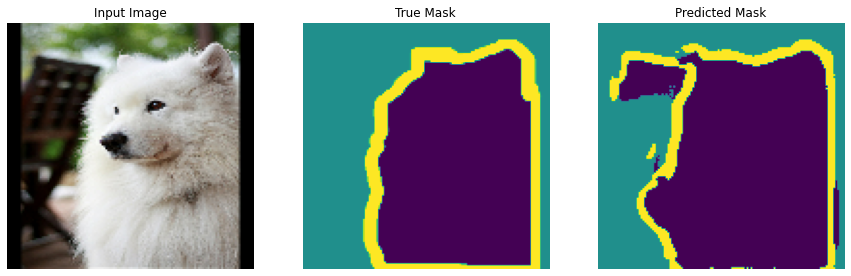

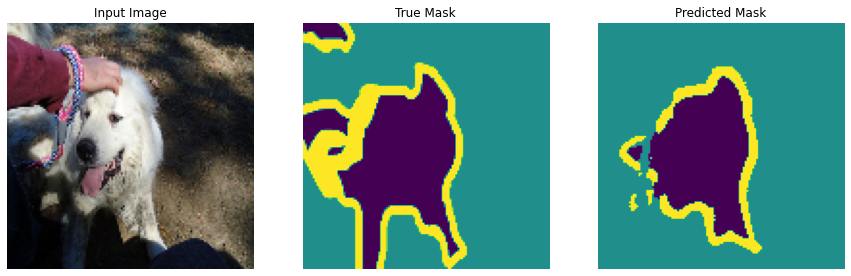

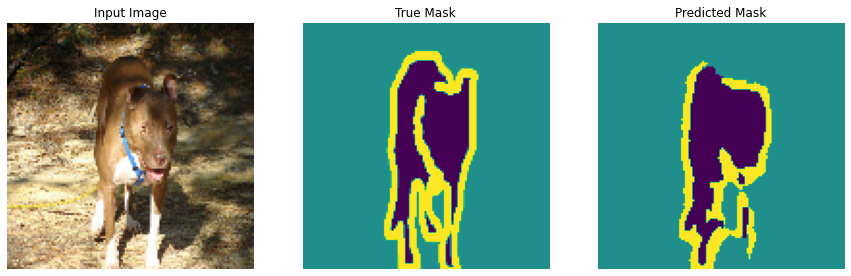

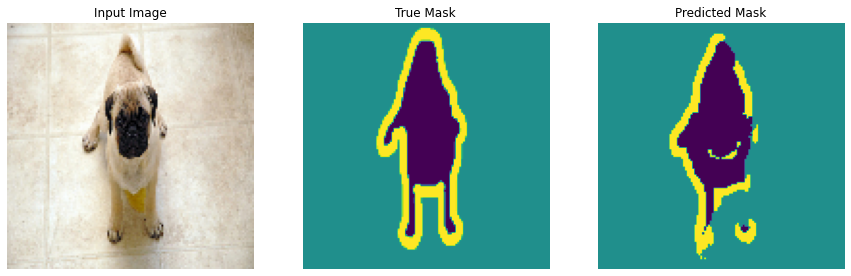

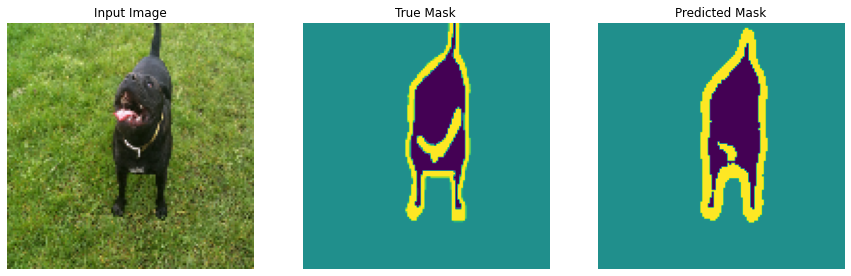

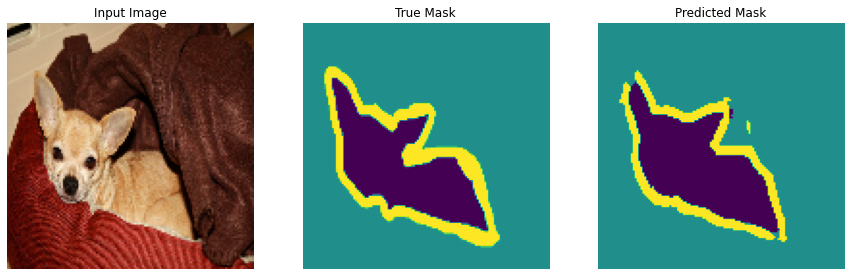

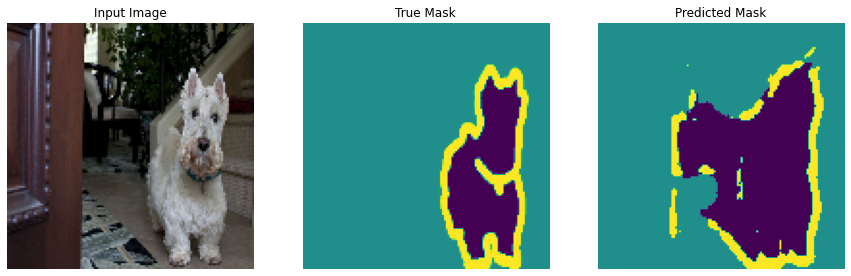

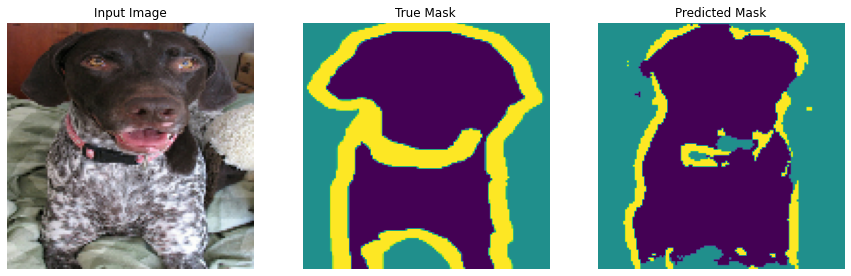

In [ ]:
show_predictions(test_dataset, 10)